# Машинное обучение, ФКН ВШЭ

## Практическое задание 6. Разложение ошибки на смещение и разброс

### Общая информация

Дата выдачи: 24.11.2021

Мягкий дедлайн: 23:59MSK 04.12.2021

Жесткий дедлайн: 23:59MSK 10.12.2021

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-06-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

В этом задании вам предстоит воспользоваться возможностями бутстрапа для оценки смещения и разброса алгоритмов машинного обучения. Делать мы это будем на данных boston:

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
from sklearn.datasets import load_boston

In [ ]:
boston = load_boston()

In [4]:
X = boston["data"]
y = boston["target"]

In [ ]:
X.shape, y.shape

((506, 13), (506,))

### Вычисление bias и variance с помощью бутстрапа
На лекции была выведено следующая формула, показывающая, как можно представить ошибку алгоритма регрессии в виде суммы трех компонент:
$$
L(\mu) = 
    \mathbb{E}_{x, y}\bigl[\mathbb{E}_{X}\bigl[ (y - \mu(X)(x))^2 \bigr]\bigr] = 
$$
$$
    \underbrace{\mathbb{E}_{x, y}\bigl[(y - \mathbb{E}[y|x] )^2\bigr]}_{\text{шум}} + \underbrace{\mathbb{E}_{x}\bigl[(\mathbb{E}_{X}[\mu(X)(x)] - \mathbb{E}[y|x] )^2\bigr]}_{\text{смещение}} +
    \underbrace{\mathbb{E}_{x}\bigl[\mathbb{E}_{X}\bigl[(\mu(X)(x) - \mathbb{E}_{X}[\mu(X)(x)] )^2\bigr]\bigr]}_{\text{разброс}},
$$
* $\mu(X)$ — алгоритм, обученный по выборке $X = \{(x_1, y_1), \dots (x_\ell, y_\ell)\}$;
* $\mu(X)(x)$ — ответ алгоритма, обученного по выборке $X$, на объекте $x$;
* $\mathbb{E}_{X}$ — мат. ожидание по всем возможным выборкам;
* $\mathbb{E}_{X}[\mu(X)(x)]$ — "средний" ответ алгоритма, обученного по всем возможным выборкам $X$, на объекте $x$.
    
С помощью этой формулы мы можем анализировать свойства алгоритма обучения модели $\mu$, если зададим вероятностную модель порождения пар $p(x, y)$.

В реальных задачах мы, конечно же, не знаем распределение на парах объект - правильный ответ. Однако у нас есть набор семплов из этого распределения (обучающую выборка), и мы можем использовать его, чтобы оценивать математические ожидания. Для оценки мат. ожиданий по выборкам мы будем пользоваться бутстрэпом - методом генерации "новых" выборок из одной с помощью выбора объектов с возвращением. Разберем несколько шагов на пути к оценке смещения и разброса.

#### Приближенное вычисление интегралов
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar z} f(\bar z)$ функции от многомерной случайной величины $\bar z = (z_1, \dots, z_d)$, $\bar z \sim p(\bar z)$, можно сгенерировать выборку из распределения $p(\bar z)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar z} f(z) = \int f(\bar z) p(\bar z) d \bar z \approx \frac 1 m \sum_{i=1}^m f(\bar z_i), \, \bar z_i \sim p(\bar z), i = 1, \dots, m.$$

Например, оценим $\mathbb{E}_z z^2,$ $z \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_z z^2 = \sigma^2 + \mu^2 = 34$):

In [ ]:
z = np.random.normal(loc=5, scale=3, size=1000)
(z**2).mean()

32.87201927321107

#### Оценивание $\mathbb{E}_{x, y}$
Оценить мат. ожидания по $x$ и по $x, y$, встречающиеся во всех трех компонентах разложения, несложно, потому что у нас есть выборка объектов из распределения данных $p(x, y)$:
$$ \mathbb{E}_{x} f(x) \approx \frac 1 N \sum_{i=1}^N f(x_i), \quad
\mathbb{E}_{x, y} f(x, y) \approx \frac 1 N \sum_{i=1}^N f(x_i, y_i),$$
где $N$ - число объектов в выборке, $\{(x_i, y_i)\}_{i=1}^N$ - сама выборка. 

#### Оценивание $\mathbb{E}_X$ с помощью бутстрапа
Чтобы оценить мат. ожидание по $X$, нам понадобится выборка из выборок:
$$\mathbb{E}_X f(X) \approx \frac 1 s \sum_{j=1}^s f(X_j),$$
где $X_j$ - $j$-я выборка. Чтобы их получить, мы можем воспользоваться бутстрапом - методом генерации выборок на основе выбора объектов с возвращением. Чтобы составить одну выборку, будем $N$ раз выбирать индекс объекта $i \sim \text{Uniform}(1 \dots N)$ и добавлять $i$-ю пару (объект, целевая переменная) в выборку. В результате в каждой выборке могут появиться повторяющиеся объекты, а какие-то объекты могут вовсе не войти в некоторые выборки.

#### Итоговый алгоритм оценки смещения и разброса алгоритма $a$
1. Сгенерировать $s$ выборок $X_j$ методом бутстрапа.
1. На каждой выборке $X_j$ обучить алгоритм $a_j$.
1. Для каждой выборки $X_j$ определить множество объектов $T_j$, не вошедших в нее (out-of-bag). Вычислить предсказания алгоритма $a_j$ на объектах $T_j$. 

Поскольку у нас есть только один ответ для каждого объекта, мы будем считать шум равным 0, а $\mathbb{E}[y|x]$ равным имеющемуся правильному ответу для объекта $x$. 

Итоговые оценки:
* Смещение: для одного объекта - квадрат разности среднего предсказания и правильного ответа. Среднее предсказание берется только по тем алгоритмам $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего смещения выполнить усреденение смещений по объектам.
* Разброс: для одного объекта - выборочная дисперсия предсказаний алгоритмов $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего разброса выполнить усреденение разбросов по объектам.
* Ошибка $L$: усреднить квадраты разностей предсказания и правильного ответа по всем выполненным предсказаниям для всех объектов.

В результате должно получиться, что ошибка приблизительно равна сумме смещения и разброса!

Алгоритм также вкратце описан по [ссылке](https://web.engr.oregonstate.edu/~tgd/classes/534/slides/part9.pdf) (слайды 19-21).

__1. (3 балла)__

Реализуйте описанный алгоритм. Обратите внимание, что если объект не вошел ни в одну из out-of-bag выборок, учитывать его в вычислении итоговых величин не нужно. Как обычно, разрешается использовать только один цикл - по выборкам (от 0 до num_runs-1).

**Мой комментарий**. Как считаем выборочную дисперсию ответов для одного объекта? Нам нужно сохранить все полученные ответы $X_1, ..., X_k$ для этого объекта на выборках $1, ..., k$, где этот объект не был выбран. Также нужно сохранить $X_1^2, ..., X_k^2$. После для этого объекта считаем $\frac{1}{k} \sum X_i^2 - \left(\frac{1}{k} \sum X_i\right)^2$. Тогда можно сохранять сумму квадратов ответов и сумму ответов, а не все ответы и квадраты ответов отдельно.

In [10]:
def compute_biase_variance(regressor, X, y, num_runs=1000):
    """
    :param regressor: sklearn estimator with fit(...) and predict(...) method
    :param X: numpy-array representing training set ob objects, shape [n_obj, n_feat]
    :param y: numpy-array representing target for training objects, shape [n_obj]
    :param num_runs: int, number of samples (s in the description of the algorithm)
    
    :returns: bias (float), variance (float), error (float) 
    each value is computed using bootstrap
    """
    N = X.shape[0]  # число объектов
    # тут для каждого объекта храним сумму предсказаний по всем выборкам, в которые он вошел:
    sum_pred = np.zeros(shape=N)
    # для вычисления выборочной дисперсии: тут будем хранить сумму квадратов ответов по тем же выборкам:
    sum_squares_pred = np.zeros(shape=N)
    # тут квадраты разностей ответов и правильных ответов по тем же выборкам для вычисления ошибки
    sum_square_error = np.zeros(shape=N)
    # тут будем сохранять, в сколько выборок попал объект
    counts = np.zeros(shape = N)

    for _ in range(num_runs):
      # --- сформируем num_runs выборок из N объектов бутстрапом ---
      # тут будем для каждого объекта отмечать, вошел ли он в выборку. сейчас массив весь из False:
      bootstrap = np.zeros(shape=N, dtype='bool')
      # N раз равновероятно выбираем индекс i из [0, 1, ..., N - 1]:
      ind = np.random.choice(a=N, size=N)  # выбранные индексы
      # выбранным объектам ставим True, остальным оставляем False:
      bootstrap[ind] = True
      out_of_bag = ~bootstrap  # True <-> False

      # обучаем на выборке, предсказываем на невошедших в нее объектах
      regressor.fit(X[bootstrap], y[bootstrap])
      cur_pred = regressor.predict(X[out_of_bag])

      # записываем нужные нам величины для объектов из out_of_bag
      sum_pred[out_of_bag] += cur_pred
      sum_squares_pred[out_of_bag] += cur_pred ** 2
      sum_square_error[out_of_bag] += (cur_pred - y[out_of_bag]) ** 2
      counts[out_of_bag] += 1

    # в array_name[counts != 0] хранятся значения для объектов, попавших хотя бы в одну выборку
    sum_pred = sum_pred[counts != 0]
    sum_squares_pred = sum_squares_pred[counts != 0]
    sum_square_error = sum_square_error[counts != 0]
    counts = counts[counts != 0]

    y_pred_mean = sum_pred/counts
    bias = (y_pred_mean - y[counts != 0]) ** 2
    variance = sum_squares_pred/counts - y_pred_mean ** 2
    
    bias_val = np.mean(bias)
    variance_val = np.mean(variance)
    error_val = sum(sum_square_error)/(sum(counts))

    return bias_val, variance_val, error_val

__2. (0 баллов)__

Оцените смещение, разброс и ошибку для трех алгоритмов с гиперпараметрами по умолчанию: линейная регрессия, решающее дерево, случайный лес.

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [ ]:
models = [LinearRegression(), DecisionTreeRegressor(), RandomForestRegressor()]

for model in models:
    bias, variance, error = compute_biase_variance(model, X, y)
    print(f"for {model}: bias = {bias}, variance = {variance}, error = {error}")

for LinearRegression(): bias = 23.693137777142333, variance = 0.575112139879312, error = 24.03139222864192
for DecisionTreeRegressor(): bias = 10.498100852559176, variance = 12.664679312940304, error = 23.06102313047868
for RandomForestRegressor(): bias = 11.086993763551733, variance = 1.4472934128734225, error = 12.462222332407006


__3. (1 балл)__
Проанализируйте полученный результат. Согласуются ли полученные результаты с теми, что мы обсуждали на занятиях (с комментарием)?

__Your answer here:__ Сначала спомним, что мы обсуждали.

Смещение метода обучения, bias, характеризует отклонение среднего ответа обученного алгоритма от ответа идеального алгоритма. Смещение показывает, насколько хорошо с помощью данных метода обучения и семейства алгоритмов можно приблизить оптимальный алгоритм. Как правило, смещение маленькое у сложных семейств (например, у деревьев) и большое у простых семейств (например, линейных классификаторов). 

Дисперсия, variance, характеризует разброс ответов обученных алгоритмов относительно среднего ответа. Дисперсия показывает, насколько сильно может изменяться ответ обученного алгоритма в зависимости от выборки --- иными словами, она характеризует чувствительность метода обучения к изменениям в выборке. Как правило, простые семейства имеют маленькую дисперсию, а сложные семейства --- большую дисперсию.

Действительно, линейная регрессия --- очень простая модель, которая не может хорошо приблизить сложные зависимости, поэтому bias высокий. Случайные деревья и леса же --- более сложные модели, поэтому приблизить истинную зависимость они могут хорошо: bias ниже (про случайный лес доказывали, что смещение относительно решающего дерева не ухудшается. Почему для дерева хорошее смещение понятно из его архитектуры). 

Про решающие деревья мы знаем, что они очень склонны к переобучению, т.к. подгоняются под обучающую выборку. И их зависимость от обучающей выборки очень сильная. Это как раз то, что показывает дисперсия. Видим, что у решающего дерева она очень высокая. 

Случайный лес каждый раз обучается на разных кусочках обучающих данных, т.е. подогнаться под них модель не может по смыслу: модель не видит все данные или хотя бы одинаковые кусочки данных во время обучения. Поэтому зависимость от обучающих данных у случайного леса небольшая: устройство модели обеспечивает разнообразие данных для обучения в самом его процессе. Архитектура такова, чтобы как раз избежать запоминания выборки. Поэтому дисперсия относительно решающих деревьев значительно снижается (помимо рассуждений на лекции строго доказывалось, что относительно отдельных деревьев дисперсия случайного леса улучшается).

У линейных моделей (простых моделей), как говорилось в лекции, маленькая дисперсия. Они не подгоняются под данные, потому что они слишком простые для этого. Поэтому результат не зависит от того, какие именно мы даем модели данные для обучения (если они одинаковой природы, конечно, как и со всеми моделями). И действительно, мы видим, что разброс у линейной регрессии --- очень низкий, ниже, чем у сложного случайного леса и очень склонного к запоминанию выборки решающего дерева.

Помним картинку с лекции с мишенями (хотя и достаточно воспользоваться здравым смыслом и определениями дисперсии и смещения) и комментарий к ней. Если у модели низкие дисперсия и смещение, то модель делает меньше ошибок. Поэтому понятно, что у случайного леса лучший показатель ошибки. У случайного леса и линейной регрессии не получается достичь хорошего показателя, т.к. или модель слишком хорошо подстраивается под обучающие данные и поэтому плохо предсказывает для новых, или в целом для наших данных закономерность описать не может, просто потому что по смыслу не может выявлять такие зависимости.

__4. (1 балл)__
Постройте бэггинг над всеми тремя моделями (линейная регрессия, решающее дерево, случайный лес). Вспомните обсуждение с лекции о том, во сколько раз в теории бэггинг уменьшает разброс базового алгоритма. Выполняется ли это в ваших экспериментах? Если нет, поясните, почему.

In [ ]:
from sklearn.ensemble import BaggingRegressor

In [ ]:
models = [LinearRegression(), DecisionTreeRegressor(), RandomForestRegressor()]

for model in models:
    bagging = BaggingRegressor(base_estimator=model)
    bias, variance, error = compute_biase_variance(bagging, X, y)
    print(f"for {model}: bias = {bias}, variance = {variance}, error = {error}")

for LinearRegression(): bias = 23.72312166039632, variance = 0.7314894425407906, error = 24.541918403552614
for DecisionTreeRegressor(): bias = 11.033577896306442, variance = 2.7095975185710115, error = 13.774990162391287
for RandomForestRegressor(): bias = 12.517564294669794, variance = 0.8590525285138838, error = 13.382085968359378


__Your answer here:__ На лекции говорилось, что если базовые модели не коррелируют, то дисперсия композиции в N раз (N --- число моделей в композиции) меньше дисперсии отдельных алгоритмов. Если модели коррелируют, то уменьшение дисперсии может быть гораздо менее существенным.

Действительно, для линейных моделей только незначительное ухудшение (композиция линейных моделей --- все еще линейная модель, пусть мы и обучили эти линейные модели на разных подвыборках. Поэтому результату лучше взяться неоткуда).

Для решающего дерева разброс улучшился значительно --- чуть меньше, чем в 6 раз. Для случайного леса --- в чуть меньше, чем 2 раза. Но дефолтное значение числа моделей в композиции для BaggingRegressor --- 10 моделей. У нас уменьшение хуже. Наши модели недостаточно хорошо не коррелируют. Например, в случайном лесе корреляция между деревьями понижается еще и за счет рандомизации по признакам. Так что понятно, что без такой рандомизации корреляция больше. Поэтому и уменьшается разброс не в 10 раз. Но, кажется, все равно неплохо.

### Визуализация предсказаний базовых алгоритмов бэггинга

В материалах лекций можно найти изображение, похожее на мишень - визуализация алгоритмов с разным смещением и разным разбросом. В центре "мишени" - правильный ответ, а "попадания" - предсказания алгоритмов, обученных по разным выборкам. Построим похожее изображение на наших данных для трех алгоритмов. Наши "мишени" будут одномерными, потому что мы решаем задачу одномерной регрессии.

__5. (2 балла)__

Реализуйте функцию plot_predictions. Она должна выполнять следующие действия:
1. Случайно выбрать num_test_objects пар объект-целевая переменная из выборки X, y. Получится две выборки: маленькая X_test, y_test (выбранные тестовые объекты) и X_train, y_train (остальные объекты).
1. Сгенерировать num_runs выборок методом бутстарапа из X_train, y_train. На каждой выборке обучить алгоритм regressor и сделать предсказания для X_test.
1. Нарисовать scatter-график. По оси абсцисс - объекты тестовой выборки (номера от 0 до num_test_objects-1), по оси ординат - предсказания. В итоге получится num_test_objects столбиков с точками. Для каждого тестового объекта надо отметить одним цветом все предсказания для него, а также черным цветом отметить правильный ответ.
1. Подпишите оси и название графика (аргумент title).

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
def plot_predictions(regressor, X, y, num_runs=100, num_test_objects=10, title=""):
    """
    plot graphics described above
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=num_test_objects)  # формируем выборки
    N = X_train.shape[0]

    for _ in range(num_runs):
      # формируем индексы выборок (как в первом задании)
      bootstrap = np.zeros(shape=N, dtype='bool')
      ind = np.random.choice(a=N, size=N)
      bootstrap[ind] = True

      # обучаем и предсказываем
      regressor.fit(X_train[bootstrap], y_train[bootstrap])
      out_pred = regressor.predict(X_test)

      plt.scatter(np.arange(num_test_objects), out_pred, c='deeppink')
      plt.ylim([0, 60])  # максимальное значение y --- 50, на случай плохого прогноза немного расширим

    plt.scatter(np.arange(num_test_objects), y_test, c='black')  # отмечаем правильный ответ
    plt.xlabel("Номер объекта из тестовой выборки")
    plt.ylim([0, 60])
    plt.ylabel("Предсказание на нем")
    plt.title(title)

__6. (0 баллов)__

Нарисуйте графики для линейной регрессии, решающего дерева и случайного леса. Нарисуйте три графика в строчку (это можно сделать с помощью plt.subplot) с одинаковой осью ординат (это важно для понимания масштаба разброса у разных алгоритмов):

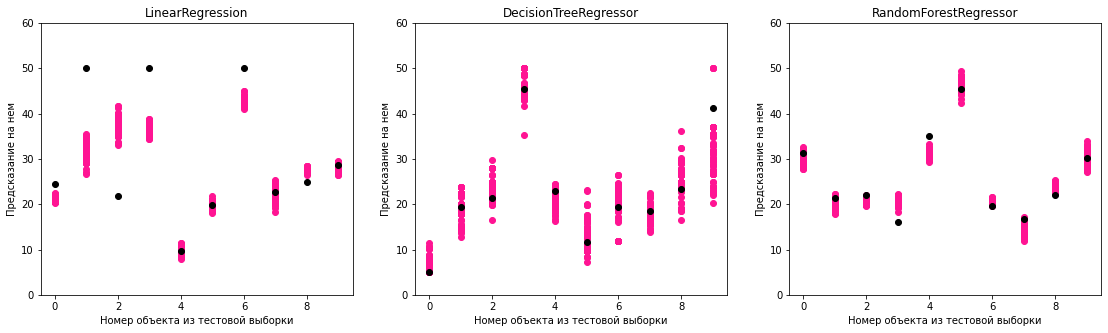

In [ ]:
plt.figure(figsize=(19, 5))

models = [LinearRegression(), DecisionTreeRegressor(), RandomForestRegressor()]
idx = 0  # номер графика

for model in models:
    idx += 1
    plt.subplot(1, 3, idx)
    plot_predictions(model, X, y, title=model.__class__.__name__)

__7. (1 балл)__

Для каждого графика прокомментируйте, как он характеризует смещение и разброс соответствующего алгоритма. 

__Your answer here:__ 

Смещение метода обучения, bias, характеризует отклонение среднего ответа обученного алгоритма от ответа идеального алгоритма. Видим, что у линейной регрессии смещение высокое: в среднем правильный ответ очень далеко от середины розового столбика. В четырех столбиках из десяти правильный ответ совпадает с средним, но во всех остальных он даже не попадает в розовый столбик, причем расстояние от столбика очень значительное. Т.е. где-то модель угадала ответ, но в целом закономерность модель не нашла: в абсолютном большинстве случаев ответ нисколько не приближен к действительному. У решающего дерева смещение очень хорошее: почти везде правильный ответ очень близок к середине розового столбика (можем смотреть на середину столбика, т.к. ответы в целом близко друг к другу расположены, поэтому средний ответ --- примерно около середины столбика). У решающего дерева смещение по качеству видим, что тоже хорошее (кажется, что похуже, чем на картинке для решающего дерева, но это связано с тем, что у нас решающее дерево и случайный лес обучаются на разных выборках: обучение => случайное взятие выборки в цикле для обучения запускается последовательно. Поэтому и результат немного отличается).

Видим, что у решающего дерева самый большой разброс ответов. А у случайного леса разброс очень маленький. У линейной регрессии разброс также маленький.

Все согласуется с тем, что мы знаем в теории: у линейной регрессии высокое смещение и маленький разброс, у решающего дерева --- маленькое смещение и высокий разброс, у случайного леса --- смещение не хуже, чем в отдельности у каждого решающего дерева, т.е. маленькое, а разброс ниже (действительно достаточно низкий).

### Изменение bias и variance при изменении гиперпараметров

__8. (0 баллов)__

Постройте графики зависимости смещения и разброса от гиперпараметров решающего дерева max_depth (от 1 до 10) и max_features (от 1 до X.shape[1]):

In [8]:
max_depths = np.arange(1, 11)
max_features_ = np.arange(1, X.shape[1] + 1)

Text(0.5, 1.0, 'Решающее дерево')

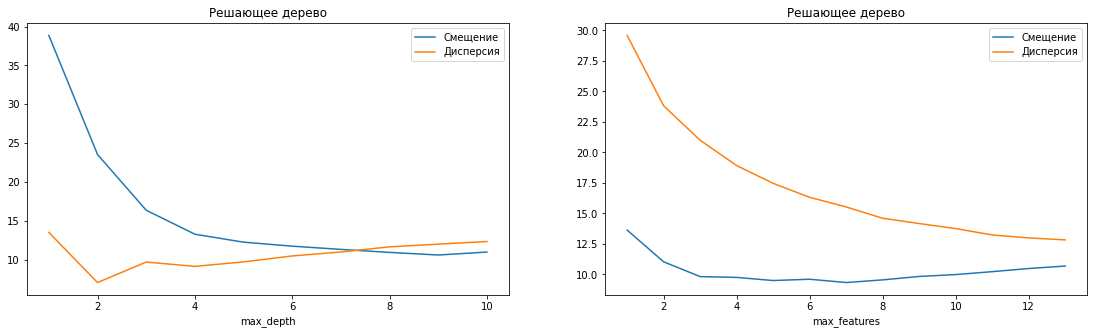

In [13]:
biases = []
variances = []
plt.figure(figsize=(19, 5))

# график зависимости от max_depth
for max_depth in max_depths:
  bias, variance, _ = compute_biase_variance(DecisionTreeRegressor(max_depth=max_depth), X, y)
  biases.append(bias)
  variances.append(variance)

plt.subplot(1, 2, 1)
plt.plot(max_depths, biases, label="Смещение")
plt.plot(max_depths, variances, label="Дисперсия")
plt.xlabel("max_depth")
plt.legend()
plt.title("Решающее дерево")

# график зависимости от max_features
biases = []
variances = []

for max_features in max_features_:
  bias, variance, _ = compute_biase_variance(DecisionTreeRegressor(max_features=max_features), X, y) 
  biases.append(bias)
  variances.append(variance)
        
plt.subplot(1, 2, 2)    
plt.plot(max_features_, biases, label="Смещение")
plt.plot(max_features_, variances, label="Дисперсия")
plt.xlabel("max_features")
plt.legend()
plt.title("Решающее дерево")

__9. (0 баллов)__

Постройте графики зависимости смещения и разброса от n_estimators (по сетке 2**np.arange(1, 10)) для случайного леса и градиентного бустинга:

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
n_estimators = 2 ** np.arange(1, 10)

Text(0.5, 1.0, 'Градиентный бустинг')

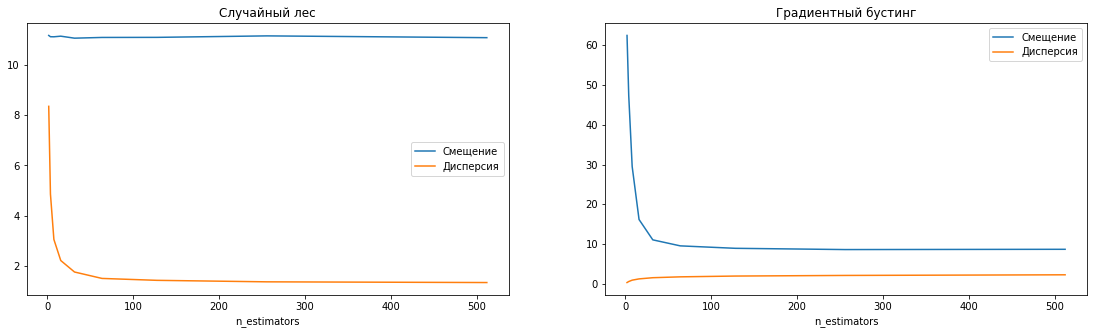

In [ ]:
plt.figure(figsize=(19, 5))

# для случайного леса
biases_rf = []
variances_rf = []

# для градиентного бустинга
biases_gb = []
variances_gb = []

for n in n_estimators:
  # для случайного леса
  bias, variance, _ = compute_biase_variance(RandomForestRegressor(n_estimators=n), X, y)
  biases_rf.append(bias)
  variances_rf.append(variance)

  # для градиентного бустинга
  bias, variance, _ = compute_biase_variance(GradientBoostingRegressor(n_estimators=n), X, y)
  biases_gb.append(bias)
  variances_gb.append(variance)

# рисуем для случайного леса
plt.subplot(1, 2, 1)
plt.plot(n_estimators, biases_rf, label="Смещение")
plt.plot(n_estimators, variances_rf, label="Дисперсия")
plt.legend()
plt.xlabel("n_estimators")
plt.title("Случайный лес")

plt.subplot(1, 2, 2)
plt.plot(n_estimators, biases_gb, label="Смещение")
plt.plot(n_estimators, variances_gb, label="Дисперсия")
plt.legend()
plt.xlabel("n_estimators")
plt.title("Градиентный бустинг")

__10. (2 балла)__

Прокомментируйте графики (всего 4 графика): почему они имеют такой вид.

__Your answer here:__ 1) С увеличением глубины решающего дерева **смещение** снижается. Это понятно: чем сложнее модель, тем более сложные зависимости она может научиться видеть. Видим, что у решающего пня **дисперсия** высокая (хотя и не самая большая, при возрастании max_features она станет выше): он реагирует на сильно выбивающиеся значения, чтобы оптимизировать функционал качества (дерево строится жадно). Поэтому зависимость от выборки очень велика, т.к. в разных выборках такие значения разные (или их вообще нет). Дерево глубины 2 же меньше реагирует, потому что может посмотреть и на другие разбиения, кроме самого вызывающего. Далее дерево уже начинает больше подгоняться под выборку. Видим, что **дисперсия** с увеличением глубины растет: чем больше дерево изучает обучающую выборку, тем больше оно под нее подгоняется по своей структуре.

2) **Разброс** уменьшается с увеличением max_features. Например, при max_features=1 модель в каждом узле должна делать разбиение по какому-то одному случайному признаку. Этот случайный признак может быть абсолютно не содержательным, до разделения по которому мы бы дошли совсем не в первую очередь. Но модель вынуждена разбить по нему, потому что это единственный признак, который у нее есть. Т.е. просто разбивает все данные по лучшему разбиению данного случайного признака. К тому же при разных запусках этот признак в каждой вершине может оказаться разным (где-то, может, совпадет, но скорее не совпадет). Поэтому, если модель получит для обучения разные данные, по одним данным какой-то случайный признак разобьется одним способом, а по другим данным уже другой случайный признак разобьется совсем другим способом. И модели будут абсолютно не похожи.

Когда же мы берем max_features побольше, модель в каждом узле разбивает разные данные пусть и по разным наборам признаков, но, раз признаков в этих наборах много, то и много признаков для разбиения совпадают. Поэтому разбиения будут более похожими, больше шансов выбрать более похожие разбиения. Поэтому модели получатся более похожими.

До max_features=5 **смещение** уменьшается, а после --- начинает увеличиваться. Сначала уменьшается, т.к. при увеличении max_features увеличивается количество данных, которые модель получает для разбиения в каждом узле (например, при max_features=1 модель делает разбиение по тому признаку, который дали, в то время как этот признак может быть совсем незначимым. Поэтому сложные закономерности модель найти не сможет). Увеличение выбора, по каким признакам делать разбиение, хотя бы до max_features=2, улучшает способность модели приблизиться к правильному алгоритму. И смещение поэтому падает по определению. После max_features=5 с увеличением этого параметра смещение начинает увеличиваться, ведь модель уже начинает подгоняется под данные $\Rightarrow$ обобщающая способность ухудшается $\Rightarrow$ способность найти настоящую зависимость, а не подстроиться под то, что дали, понижается. На мысли немного натолкнула эта [статья](https://towardsdatascience.com/random-forests-and-the-bias-variance-tradeoff-3b77fee339b4).

*Это объяснение, если бы мы брали композицию деревьев фиксированной глубины. Думала, что картинка для бэггинга, и написала его. Оно очень красивое и многострадальное, не могу просто так удалить...* С увеличением max_features, т.к. выборки бутстрапированные, увеличивается число способов выбрать лучшее разбиение (т.к. мы выбираем по большему числу признаков. Выборки разные, поэтому разбиения не получатся одинаковые). Поэтому базовые модели становятся все более непохожими друг на друга. Поэтому **разброс** уменьшается (мы говорили, что чем более непохожие друг на друга базовые модели в бэггинге, тем меньше разброс).

3) **Смещение** случайного леса равно смещению одной базовой модели $\Rightarrow$ смещение примерно одинаковое вне зависимости от числа моделей в композиции. Т.к. модели хоть сколько-то не коррелируют, с добавлением каждой новой мы получаем **дисперсию** композиции меньше. Хотя при очень большом количестве схожесть новой модели с какой-то из уже добавленных высокая, поэтому дисперсия перестает уменьшаться так резко, как где-то до n_estimators=70.  

4) Вспомним архитектуру градиентного бустинга. Уже построена композиция $a_{N - 1}$ из N - 1 алгоритма, хотим построить следующий базовый алгоритм $b_n$ так, чтобы композиция $a_{N - 1}$ и $b_n$ с каким-то весом как можно сильнее уменьшала ошибку. Поэтому из устройства модели с увеличением числа моделей, которые мы строим, мы получаем модель, которая может все лучше и лучше находить сложные закономерности в данных. Поэтому **смещение** уменьшается. В какой-то момент стабилизируется, т.к. есть еще такая компонента ошибки, как шум. **Дисперсия** растет, т.к. чуть повышается подгон под обучающие данные (посмотрела [тут](https://medium.com/gradient-boosting-working-limitations-time/gradient-boosting-working-and-applications-28e8d4ba866d)).

Вставьте картинку, описывающую ваш опыт выполнения этого ДЗ.

картинка, описывающая опыт преподавателей от моего выполнения этого дз: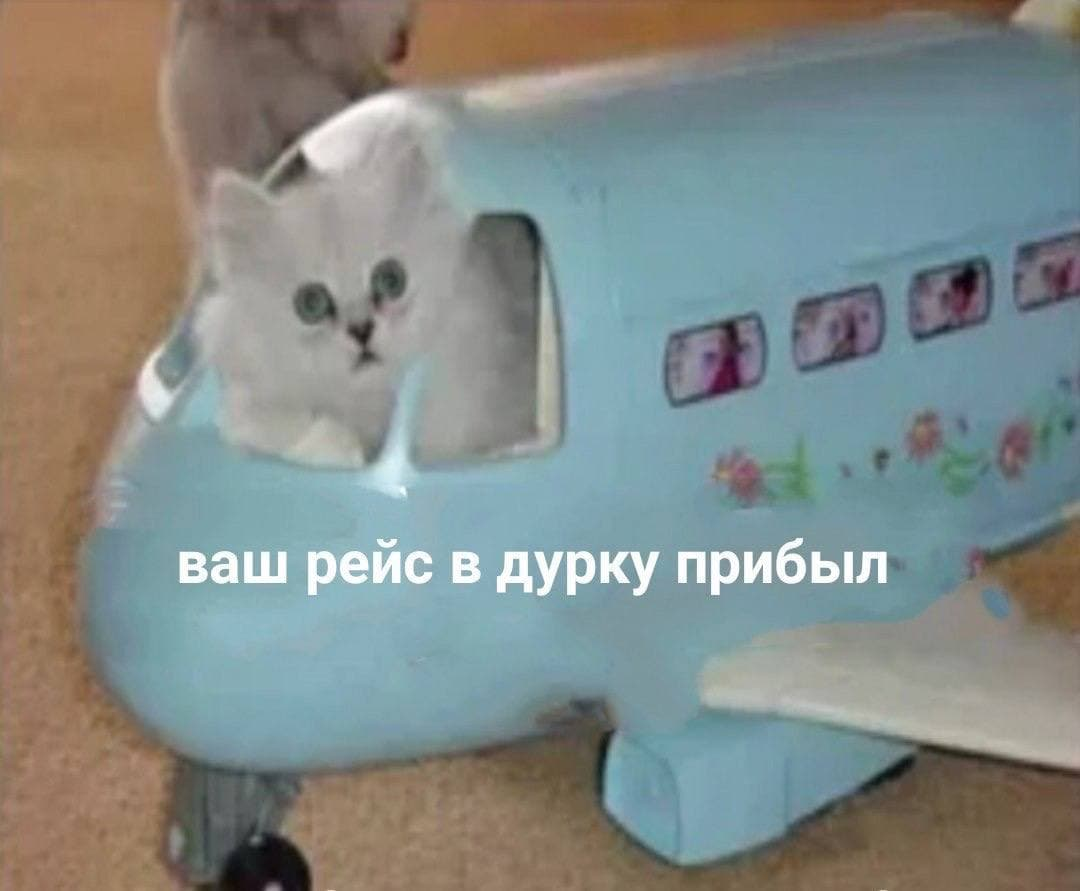

я: \*печатаю\*

семинаристы и ассистенты в чате: 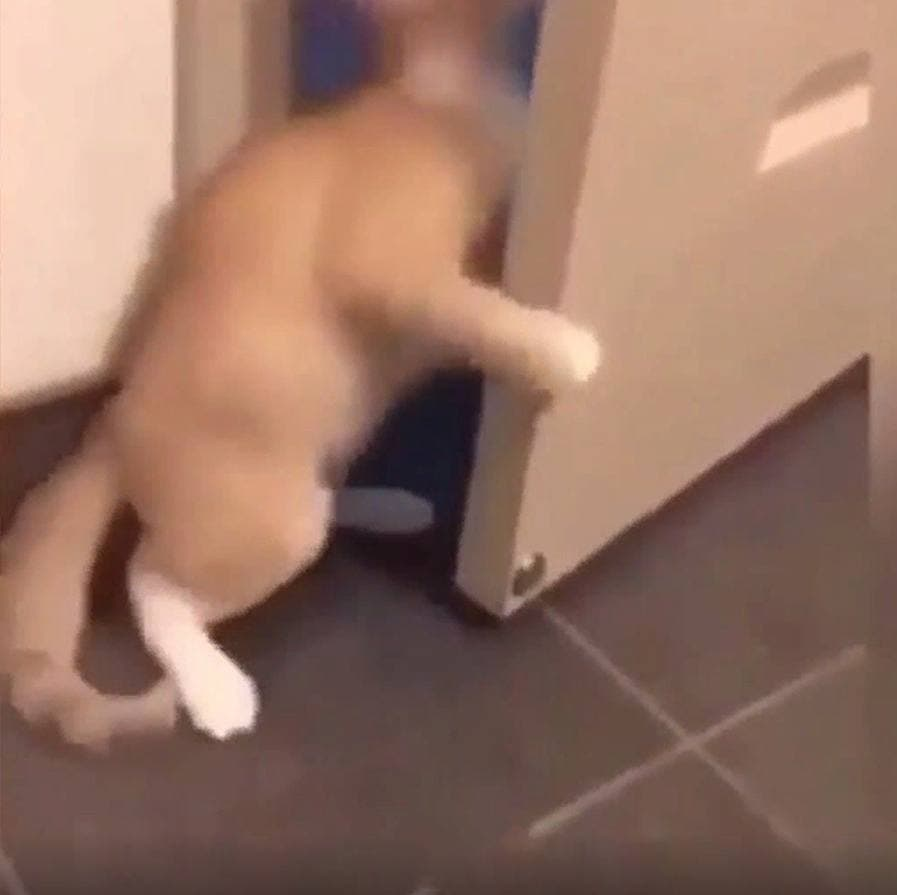